# **Crypto market capitalization forecast based on S&P 500.**

## **Abstract**
   Abstract here. Give an executive summary of your project: goal, methods, results, conclusions. Usually no more than 200 words.


## **Introduction**

Here you have to explain the problem that you are solving. Explain why it is important, and what are the main challenges. Mention previous attempts (add papers as references) to solve it. Mainly focus on the techniques closely related to our approach. Briefly describe your approach and explain why it is promising for solving the addressed problem. Mention the dataset and the main results achieved.

In this section, you can add **text** and **figures**.

## **Methodology**
Describe the important steps you took to achieve your goal. Focus more on the most important steps (preprocessing, extra features, model aspects) that turned out to be important. Mention the original aspects of the project and state how they relate to existing work.

In this section, you can add **text** and **figures**. For instance, it is strongly suggested to add a picture of the best machine learning model that you implemented to solve your problem (and describe it).


### **Preprocessing**

The first step in our methodology involved preprocessing the raw data from three CSV files: one containing cryptocurrency market data (e.g., Aave), another one containing S&P 500 historical data, and the final one containing the fear index of the S&P500 (VIX). For the cryptocurrency data, we focused on key features such as Date, Volume, and Marketcap. Similarly, for the S&P 500 data, we retained relevant columns like Date, Open, High, Low, Close, Volume, and additional info regarding the fear index. The datasets were cleaned to handle missing values, if any, unwanted data and the Date columns were standardized to ensure compatibility for merging.

First Let's import the necessary libraries that we need for the project!  
Run the code below...


In [28]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Once the libraries imported, we can now load the data and take a look at the first few rows along with some additional info by running the code below.

In [25]:
KAGGLE_DATA_PATH = 'KaggleData/'

def load_data(filename: str, date_col: str, date_format: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame and parses the date column.

    Args:
        filename (str): Name of the CSV file.
        date_col (str): Name of the date column.
        date_format (str): Format of the date in the CSV.

    Returns:
        pd.DataFrame: Processed DataFrame with parsed dates.
    """
    filepath = os.path.join(KAGGLE_DATA_PATH, filename)
    df = pd.read_csv(filepath)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format)
    return df

crypto_df = load_data('All_Crypto.csv', 'Date', '%d-%m-%Y %H:%M')
stock_df = load_data('spy.csv', 'Date', '%Y-%m-%d')
vix_df = load_data('vix_daily.csv', 'Date', '%Y-%m-%d')

for name, df in zip(["Crypto", "Stock", "VIX"], [crypto_df, stock_df, vix_df]):
    print(f"\n{name} Dataset Preview:")
    print(df.head())

for name, df in zip(["Crypto", "Stock", "VIX"], [crypto_df, stock_df, vix_df]):
    print(f"\n{name} Dataset ==> Min Date: {df['Date'].min()} / Max Date: {df['Date'].max()}")



Crypto Dataset Preview:
   Sno  Name Symbol                Date       High        Low       Open  \
0    1  Aave   AAVE 2020-10-05 23:59:00  55.112358  49.787900  52.675035   
1    2  Aave   AAVE 2020-10-06 23:59:00  53.402270  40.734578  53.291969   
2    3  Aave   AAVE 2020-10-07 23:59:00  42.408314  35.970690  42.399947   
3    4  Aave   AAVE 2020-10-08 23:59:00  44.902511  36.696057  39.885262   
4    5  Aave   AAVE 2020-10-09 23:59:00  47.569533  43.291776  43.764463   

       Close        Volume     Marketcap  
0  53.219243  0.000000e+00  8.912813e+07  
1  42.401599  5.830915e+05  7.101144e+07  
2  40.083976  6.828342e+05  6.713004e+07  
3  43.764463  1.658817e+06  2.202651e+08  
4  46.817744  8.155377e+05  2.356322e+08  

Stock Dataset Preview:
        Date       Open       High        Low      Close   Volume  Day  \
0 1993-01-29  24.543517  24.543517  24.421410  24.526073  1003200   29   
1 1993-02-01  24.543515  24.700510  24.543515  24.700510   480500    1   
2 1993-02-02  

#### Crypto data

Let us focus on preprocessing the crypto data first. We can tackle afterwards the S&P500.


Let us see how many crypto coins we are dealing with by running the following code.

In [6]:
unique_crypto_names = crypto_df['Name'].unique()
print(f"Total Unique Cryptocurrencies: {len(unique_crypto_names)}")
print(", ".join(unique_crypto_names)) 


Total Unique Cryptocurrencies: 23
Aave, Binance Coin, Bitcoin, Cardano, Chainlink, Cosmos, Crypto.com Coin, Dogecoin, EOS, Ethereum, IOTA, Litecoin, Monero, NEM, Polkadot, Solana, Stellar, Tether, TRON, Uniswap, USD Coin, XRP, Wrapped Bitcoin


There are 23 crypto currencies in the data we are using. Even though we would have preferred to have data about all the top 100 crypto currencies, this should also be fine for the scope of this project.  
However, there are some cryptocurrencies that we would want to discard here like stable coins and currencies that are not in the top 100.  
The reason we want to discard stablecoins is because they are designed to maintain a fixed value (usually pegged to the USD), so their market cap changes are primarily driven by issuance and redemption rather than market speculation or macroeconomic factors. Including them might introduce noise rather than meaningful predictive signals.  
In this case, we are discarding `Crypto.com Coin`, `NEM`, `Tether`, `USD Coin`, and `Wrapped Bitcoin`.

In [7]:
EXCLUDE_LIST = {'Crypto.com Coin', 'NEM', 'Tether', 'USD Coin', 'Wrapped Bitcoin'}
crypto_df_filtered = crypto_df[~crypto_df['Name'].isin(EXCLUDE_LIST)]
print(f"Remaining Cryptocurrencies After Filtering: {crypto_df_filtered['Name'].nunique()}")


Remaining Cryptocurrencies After Filtering: 18


We should now take a look at the completness of the data from a range that I have educationally chosen (2018-01-01 to 2021-06-07).  
By running the two cells below, we notice that some crypto currencies have been created after 2018, thus they would have no data from the year 2018 to the year that they have been created.  
This is an issue.  

In [8]:
date_range = pd.date_range(start='2018-01-01', end='2021-06-07', freq='D')

recent_cryptos = []
original_cryptos = []

# Group by 'Name' and check for missing dates
for name, group in crypto_df_filtered.groupby('Name'):
    unique_dates = group['Date'].dt.normalize().unique() 
    missing_dates = set(date_range) - set(unique_dates) 

    (recent_cryptos if missing_dates else original_cryptos).append(name)

print(f"Cryptos with complete data: {len(original_cryptos)} -> {original_cryptos}")
print(f"Cryptos missing some dates: {len(recent_cryptos)} -> {recent_cryptos}")


Cryptos with complete data: 13 -> ['Binance Coin', 'Bitcoin', 'Cardano', 'Chainlink', 'Dogecoin', 'EOS', 'Ethereum', 'IOTA', 'Litecoin', 'Monero', 'Stellar', 'TRON', 'XRP']
Cryptos missing some dates: 5 -> ['Aave', 'Cosmos', 'Polkadot', 'Solana', 'Uniswap']


Following this I have decided on doing the project in 2 different experiments:  
1. Include all crypto currencies that have data that range from 2018 or earlier to 2021.  
2. Include all crypto currencies that have data that range from the `last date a crypto was created` to 2021.  

This means that `option 1` will have less crypto currency diversity, but have a longer time frame, and `option 2`, will have a wider  crypto currency diversity on a smaller time frame.

Let us create the dataset for `option 1`. (Full time frame)

In [9]:
min_start_dates = crypto_df_filtered.loc[crypto_df_filtered['Name'].isin(original_cryptos)] \
                                   .groupby('Name')['Date'].min()
latest_common_start = min_start_dates.max()

max_date = crypto_df['Date'].max()

full_time_frame_crypto_df = crypto_df_filtered[
    (crypto_df_filtered['Name'].isin(original_cryptos)) &
    (crypto_df_filtered['Date'].between(latest_common_start, max_date))
]

print(f"Dataset includes cryptos from {latest_common_start.date()} to {max_date.date()} "
      f"with {full_time_frame_crypto_df['Name'].nunique()} cryptos.")


Dataset includes cryptos from 2017-10-02 to 2021-07-06 with 13 cryptos.


Let us now create the dataset for `option 2`. (Partial time frame)

In [10]:
latest_start_date = crypto_df_filtered.groupby('Name')['Date'].min().max()
partial_time_frame_crypto_df = crypto_df_filtered[crypto_df_filtered['Date'] >= latest_start_date]

print(f"Dataset includes cryptos from {latest_start_date.date()} to {partial_time_frame_crypto_df['Date'].max().date()} "
      f"with {partial_time_frame_crypto_df['Name'].nunique()} cryptos.")



Dataset includes cryptos from 2020-10-05 to 2021-07-06 with 18 cryptos.


#### S&P500 Data

Let us now process the stock market data.  
From what we have accomplished before, we know that we need to match the date ranges of our crypto data. Which means we will have `full_time_frame_stock_df` and a `partial_time_frame_stock_df` that range from `2017-10-02` to `2021-07-06` and from `2020-10-05` to `2021-07-06` respectively.

We also need to keep in mind that the stock market closes on the weekends. Thus, for the sake of this project, we will assume that the last available price (Friday’s) carries over to Saturday and Sunday since stock prices don’t change on weekends.  
We will use Forward fill to accomplish this.  
This will keep the dataset aligned with the crypto data. Also, it reflects the reality that stock prices remain unchanged on weekends.
Same thing will be done to the VIX data frame as well.

In [11]:
full_start_date, partial_start_date, end_date = "2017-10-02", "2020-10-05", "2021-07-06"

def handle_closed_weekends(df: pd.DataFrame, start_date: str, end_date: str, date_col: str = 'Date') -> pd.DataFrame:
    """
    Filters a dataframe within a date range, expands it to include weekends,
    and forward-fills missing values.
    
    Args:
        df (pd.DataFrame): The original dataframe with a date column.
        start_date (str): The start date for filtering.
        end_date (str): The end date for filtering.
        date_col (str): The name of the date column. Defaults to 'Date'.
    
    Returns:
        pd.DataFrame: Processed data with weekends included and missing values filled.
    """
    filtered_df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()

    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Reindex to ensure weekends are included, then forward-fill missing values
    return (
        filtered_df.set_index(date_col)
        .reindex(date_range)
        .ffill()
        .reset_index()
        .rename(columns={'index': date_col})
    )

In [12]:
# Preprocess stock data
full_time_frame_stock_df = handle_closed_weekends(stock_df, full_start_date, end_date)
partial_time_frame_stock_df = handle_closed_weekends(stock_df, partial_start_date, end_date)

# Print results
print(f"Full S&P500 dataset: {full_time_frame_stock_df['Date'].min()} to {full_time_frame_stock_df['Date'].max()} "
      f"with {len(full_time_frame_stock_df)} rows")
print(f"Partial S&P500 dataset: {partial_time_frame_stock_df['Date'].min()} to {partial_time_frame_stock_df['Date'].max()} "
      f"with {len(partial_time_frame_stock_df)} rows")

Full S&P500 dataset: 2017-10-02 00:00:00 to 2021-07-06 00:00:00 with 1374 rows
Partial S&P500 dataset: 2020-10-05 00:00:00 to 2021-07-06 00:00:00 with 275 rows


In [13]:
# Preprocess VIX data
full_time_frame_vix_df = handle_closed_weekends(vix_df, full_start_date, end_date)
partial_time_frame_vix_df = handle_closed_weekends(vix_df, partial_start_date, end_date)

# Print results
print(f"Full VIX dataset: {full_time_frame_vix_df['Date'].min()} to {full_time_frame_vix_df['Date'].max()} "
      f"with {len(full_time_frame_vix_df)} rows")
print(f"Partial VIX dataset: {partial_time_frame_vix_df['Date'].min()} to {partial_time_frame_vix_df['Date'].max()} "
      f"with {len(partial_time_frame_vix_df)} rows")

Full VIX dataset: 2017-10-02 00:00:00 to 2021-07-06 00:00:00 with 1374 rows
Partial VIX dataset: 2020-10-05 00:00:00 to 2021-07-06 00:00:00 with 275 rows


We can now save all the data frames as csvs. Might be useful later!

In [2]:
PROCESSED_DATA_PATH = 'ProcessedData/'
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

def save_to_csv(df: pd.DataFrame, filename: str) -> None:
    """
    Saves a DataFrame to a CSV file in the processed data directory.
    
    Args:
        df (pd.DataFrame): The DataFrame to save.
        filename (str): The name of the CSV file.
    """
    filepath = os.path.join(PROCESSED_DATA_PATH, filename)
    df.to_csv(filepath, index=False)
    print(f"Saved {filename} to {filepath}")

In [15]:
# Save all processed DataFrames
save_to_csv(full_time_frame_crypto_df, 'full_time_frame_crypto_data.csv')
save_to_csv(partial_time_frame_crypto_df, 'partial_time_frame_crypto_data.csv')
save_to_csv(full_time_frame_stock_df, 'full_time_frame_stock_data.csv')
save_to_csv(partial_time_frame_stock_df, 'partial_time_frame_stock_data.csv')
save_to_csv(full_time_frame_vix_df, 'full_time_frame_vix_data.csv')
save_to_csv(partial_time_frame_vix_df, 'partial_time_frame_vix_data.csv')

Saved full_time_frame_crypto_data.csv to ProcessedData/full_time_frame_crypto_data.csv
Saved partial_time_frame_crypto_data.csv to ProcessedData/partial_time_frame_crypto_data.csv
Saved full_time_frame_stock_data.csv to ProcessedData/full_time_frame_stock_data.csv
Saved partial_time_frame_stock_data.csv to ProcessedData/partial_time_frame_stock_data.csv
Saved full_time_frame_vix_data.csv to ProcessedData/full_time_frame_vix_data.csv
Saved partial_time_frame_vix_data.csv to ProcessedData/partial_time_frame_vix_data.csv


#### Merging the datasets

Perfect, now that we have cleaned the data, we still have a couple more steps before starting to play with models.  
Steps:  
- Extract the global volume and global market cap for each day in the crypto data.
- Merge the stock, vix, and crypto market data together.

In [16]:
def aggregate_crypto_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates crypto data by date, summing 'Volume' and 'Marketcap',
    and renames the columns for clarity.
    
    Args:
        df (pd.DataFrame): The input DataFrame with 'Date', 'Volume', and 'Marketcap' columns.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with 'Date', 'Total_Volume', and 'Total_Market_Cap'.
    """
    aggregated_df = (
        df.groupby('Date', as_index=False)
        .agg({'Volume': 'sum', 'Marketcap': 'sum'})
        .rename(columns={'Volume': 'Total_Volume', 'Marketcap': 'Total_Market_Cap'})
    )
    # Remove time from the 'Date' column for better compactness
    aggregated_df['Date'] = aggregated_df['Date'].dt.date
    return aggregated_df

In [17]:
# Aggregate full and partial time frame crypto data
full_time_frame_crypto_aggregated_df = aggregate_crypto_data(full_time_frame_crypto_df)
partial_time_frame_crypto_aggregated_df = aggregate_crypto_data(partial_time_frame_crypto_df)

print("Full time frame crypto aggregate data: \n", full_time_frame_crypto_aggregated_df.head())
print("\nPartial time frame crypto aggregate data: \n", partial_time_frame_crypto_aggregated_df.head(), '\n')

save_to_csv(full_time_frame_crypto_aggregated_df, 'full_time_frame_aggregate_crypto_data.csv')
save_to_csv(partial_time_frame_crypto_aggregated_df, 'partial_time_frame_aggregate_crypto_data.csv')

Full time frame crypto aggregate data: 
          Date  Total_Volume  Total_Market_Cap
0  2017-10-02  2.084329e+09      1.166802e+11
1  2017-10-03  1.857098e+09      1.145126e+11
2  2017-10-04  1.648587e+09      1.134182e+11
3  2017-10-05  1.965073e+09      1.162994e+11
4  2017-10-06  1.711230e+09      1.180752e+11

Partial time frame crypto aggregate data: 
          Date  Total_Volume  Total_Market_Cap
0  2020-10-05  7.121521e+10      2.789262e+11
1  2020-10-06  7.336479e+10      2.719265e+11
2  2020-10-07  6.273427e+10      2.734531e+11
3  2020-10-08  9.018118e+10      2.803745e+11
4  2020-10-09  4.923914e+10      2.861705e+11 

Saved full_time_frame_aggregate_crypto_data.csv to ProcessedData/full_time_frame_aggregate_crypto_data.csv
Saved partial_time_frame_aggregate_crypto_data.csv to ProcessedData/partial_time_frame_aggregate_crypto_data.csv


In [18]:
def process_dataset(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    """
    Processes a dataset by converting the 'Date' column to datetime,
    dropping unnecessary columns, and renaming columns for clarity.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        dataset_type (str): The type of dataset ('crypto', 'stock', or 'vix').
    
    Returns:
        pd.DataFrame: Processed DataFrame.
    """
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Process based on dataset type
    if dataset_type == 'stock':
        df = df.drop(['Day', 'Weekday', 'Week', 'Month', 'Year'], axis=1)
        df = df.rename(columns={
            'Open': 'S&P500_Open',
            'High': 'S&P500_High',
            'Low': 'S&P500_Low',
            'Close': 'S&P500_Close',
            'Volume': 'S&P500_Volume'
        })
    elif dataset_type == 'crypto':
        df = df.rename(columns={
            'Total_Volume': 'Crypto_Volume',
            'Total_Market_Cap': 'Crypto_Market_Cap'
        })
    elif dataset_type == 'vix':
        df = df.rename(columns={
            'Open': 'VIX_Open',
            'High': 'VIX_High',
            'Low': 'VIX_Low',
            'Close': 'VIX_Close'
        })
    else:
        raise ValueError(f"Invalid dataset type: {dataset_type}. Expected 'crypto', 'stock', or 'vix'.")
    
    return df

In [19]:
full_time_frame_crypto_aggregated_df = process_dataset(full_time_frame_crypto_aggregated_df, 'crypto')
full_time_frame_stock_df = process_dataset(full_time_frame_stock_df, 'stock')
full_time_frame_vix_df = process_dataset(full_time_frame_vix_df, 'vix')

partial_time_frame_crypto_aggregated_df = process_dataset(partial_time_frame_crypto_aggregated_df, 'crypto')
partial_time_frame_stock_df = process_dataset(partial_time_frame_stock_df, 'stock')
partial_time_frame_vix_df = process_dataset(partial_time_frame_vix_df, 'vix')

Let us now merge the crypto, stock, and VIX market data!

In [20]:
merged_df1 = pd.merge(full_time_frame_crypto_aggregated_df, full_time_frame_stock_df, on='Date', how='inner')
full_time_merged_df = pd.merge(merged_df1, full_time_frame_vix_df, on='Date', how='inner')

merged_df2 = pd.merge(partial_time_frame_crypto_aggregated_df, partial_time_frame_stock_df, on='Date', how='inner')
partial_time_merged_df = pd.merge(merged_df2, partial_time_frame_vix_df, on='Date', how='inner')

print('Merged data for full time: \n', full_time_merged_df.head())
print('Merged data for partial time: \n', partial_time_merged_df.head())

Merged data for full time: 
         Date  Crypto_Volume  Crypto_Market_Cap  S&P500_Open  S&P500_High  \
0 2017-10-02   2.084329e+09       1.166802e+11   223.421919   224.159286   
1 2017-10-03   1.857098e+09       1.145126e+11   224.159281   224.665658   
2 2017-10-04   1.648587e+09       1.134182e+11   224.487941   225.154236   
3 2017-10-05   1.965073e+09       1.162994e+11   225.243074   226.255841   
4 2017-10-06   1.711230e+09       1.180752e+11   225.784976   226.273594   

   S&P500_Low  S&P500_Close  S&P500_Volume  VIX_Open  VIX_High  VIX_Low  \
0  223.244229    224.159286     59023000.0      9.59     10.04     9.37   
1  224.079316    224.639008     66810200.0      9.30      9.75     9.30   
2  224.372446    224.905487     55953600.0      9.53      9.88     9.53   
3  224.941024    226.238083     63522800.0      9.48      9.62     9.13   
4  225.518469    225.980423     80646000.0      9.23     10.27     9.11   

   VIX_Close  
0       9.45  
1       9.51  
2       9.63  
3  

In [21]:
# Save the merged data
save_to_csv(full_time_merged_df, 'full_time_merged_data.csv')
save_to_csv(partial_time_merged_df, 'partial_time_merged_data.csv')

Saved full_time_merged_data.csv to ProcessedData/full_time_merged_data.csv
Saved partial_time_merged_data.csv to ProcessedData/partial_time_merged_data.csv


**And we're done for the preprocessing part!**

### **Processing**

Now that we have our merged, cleaned, and well structured dataset, let us dive have a small peak about its different features!  
We can understand it more this way.  
Run the code below to see what our data looks like!

In [3]:
# Load the dataset that we are going to use
df = pd.read_csv(PROCESSED_DATA_PATH + 'full_time_merged_data.csv')
df.head()


,Date,Crypto_Volume,Crypto_Market_Cap,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume,VIX_Open,VIX_High,VIX_Low,VIX_Close
0,2017-10-02,2.084329e+09,1.166802e+11,223.421919,224.159286,223.244229,224.159286,59023000.0,9.59,10.04,9.37,9.45
1,2017-10-03,1.857098e+09,1.145126e+11,224.159281,224.665658,224.079316,224.639008,66810200.0,9.30,9.75,9.30,9.51
2,2017-10-04,1.648587e+09,1.134182e+11,224.487941,225.154236,224.372446,224.905487,55953600.0,9.53,9.88,9.53,9.63
3,2017-10-05,1.965073e+09,1.162994e+11,225.243074,226.255841,224.941024,226.238083,63522800.0,9.48,9.62,9.13,9.19
4,2017-10-06,1.711230e+09,1.180752e+11,225.784976,226.273594,225.518469,225.980423,80646000.0,9.23,10.27,9.11,9.65


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Crypto_Volume,1374.0,4.678761e+10,4.769453e+10,1.496680e+09,1.128685e+10,3.286869e+10,6.284234e+10,5.957234e+11
Crypto_Market_Cap,1374.0,3.741312e+11,3.874965e+11,8.559126e+10,1.739529e+11,2.262254e+11,3.234868e+11,1.932517e+12
S&P500_Open,1374.0,2.835170e+02,4.848634e+01,2.128046e+02,2.464035e+02,2.666699e+02,3.086846e+02,4.123649e+02
S&P500_High,1374.0,2.850793e+02,4.854677e+01,2.141941e+02,2.483661e+02,2.682213e+02,3.100502e+02,4.126692e+02
S&P500_Low,1374.0,2.817166e+02,4.845217e+01,2.035441e+02,2.453399e+02,2.645780e+02,3.070214e+02,4.092659e+02
S&P500_Close,1374.0,2.835394e+02,4.859567e+01,2.079179e+02,2.467131e+02,2.669779e+02,3.091474e+02,4.123080e+02
S&P500_Volume,1374.0,8.859524e+07,5.050326e+07,2.027000e+07,5.730830e+07,7.500640e+07,1.024504e+08,3.922207e+08
VIX_Open,1374.0,1.991120e+01,9.573421e+00,9.010000e+00,1.346000e+01,1.731000e+01,2.299000e+01,8.269000e+01
VIX_High,1374.0,2.118347e+01,1.048557e+01,9.310000e+00,1.426000e+01,1.840500e+01,2.458500e+01,8.547000e+01
VIX_Low,1374.0,1.860314e+01,8.472860e+00,8.560000e+00,1.281000e+01,1.619500e+01,2.170250e+01,7.037000e+01


In [5]:
print("Dataset shape: ", df.shape)
# Take a look at the types of the dataset
print(df.dtypes)
# Make sure our dataset holds no missing values
print(df.isna().sum())



Dataset shape:  (1374, 12)
Date                  object
Crypto_Volume        float64
Crypto_Market_Cap    float64
S&P500_Open          float64
S&P500_High          float64
S&P500_Low           float64
S&P500_Close         float64
S&P500_Volume        float64
VIX_Open             float64
VIX_High             float64
VIX_Low              float64
VIX_Close            float64
dtype: object
Date                 0
Crypto_Volume        0
Crypto_Market_Cap    0
S&P500_Open          0
S&P500_High          0
S&P500_Low           0
S&P500_Close         0
S&P500_Volume        0
VIX_Open             0
VIX_High             0
VIX_Low              0
VIX_Close            0
dtype: int64


Now that we know a bit more about our dataset, lets try to take a look at our labels (the actual feature that we are trying to predict).  
In our case we can plot our labels (Crypto_Market_Cap) across time.
Run the code below to 

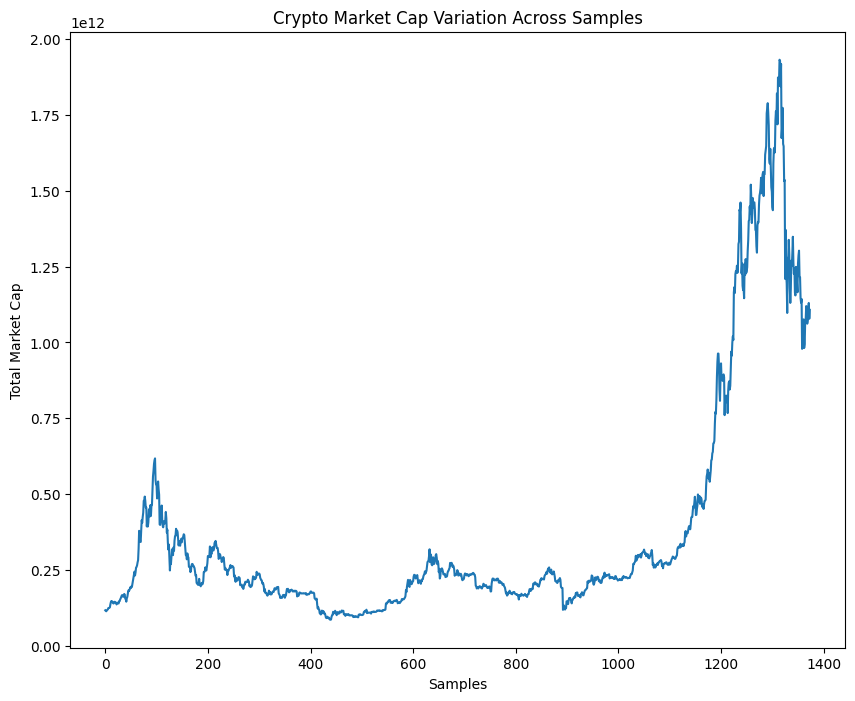

In [6]:
plt.figure(figsize = (10,8))
plt.xlabel('Samples')
plt.ylabel("Total Market Cap")
plt.title('Crypto Market Cap Variation Across Samples')
plt.plot(df['Crypto_Market_Cap'])
plt.show()

How about some other important features?

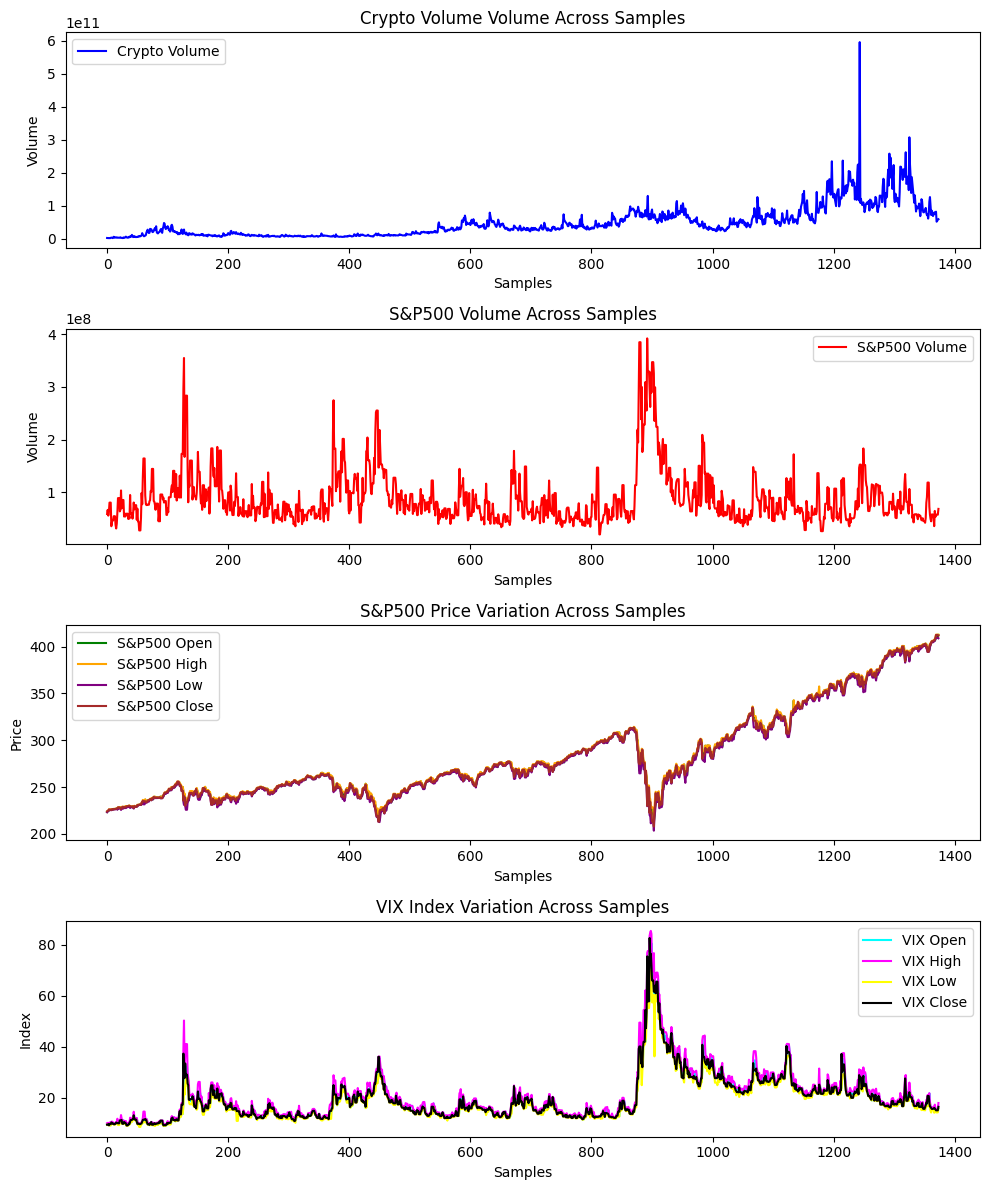

In [7]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# First plot: Crypto Volume Volume
axes[0].plot(df.index, df['Crypto_Volume'], label='Crypto Volume', color='blue')
axes[0].set_title('Crypto Volume Volume Across Samples')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Volume')
axes[0].legend()

# Second plot: S&P500 Volume
axes[1].plot(df.index, df['S&P500_Volume'], label='S&P500 Volume', color='red')
axes[1].set_title('S&P500 Volume Across Samples')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Volume')
axes[1].legend()

# Third plot: S&P500 Prices
axes[2].plot(df.index, df['S&P500_Open'], label='S&P500 Open', color='green')
axes[2].plot(df.index, df['S&P500_High'], label='S&P500 High', color='orange')
axes[2].plot(df.index, df['S&P500_Low'], label='S&P500 Low', color='purple')
axes[2].plot(df.index, df['S&P500_Close'], label='S&P500 Close', color='brown')
axes[2].set_title('S&P500 Price Variation Across Samples')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Price')
axes[2].legend()

# Fourth plot: VIX Prices
axes[3].plot(df.index, df['VIX_Open'], label='VIX Open', color='cyan')
axes[3].plot(df.index, df['VIX_High'], label='VIX High', color='magenta')
axes[3].plot(df.index, df['VIX_Low'], label='VIX Low', color='yellow')
axes[3].plot(df.index, df['VIX_Close'], label='VIX Close', color='black')
axes[3].set_title('VIX Index Variation Across Samples')
axes[3].set_xlabel('Samples')
axes[3].set_ylabel('Index')
axes[3].legend()

plt.tight_layout()
plt.show()


Additionally, discvering the corelations between variables is also a crucial step. By running the code below, we can see what features are most correlated to out target feature.

**Side note**: Here I decided to use **Spearman correlation** because it is better for predicting crypto market cap changes based on S&P 500. It measures the monotonic relationship between variables rather than assuming a strictly linear one like Pearson. Since financial markets often exhibit non-linear dependencies, where crypto and S&P 500 might move in the same general direction but not at a constant rate, Spearman is more robust in capturing such patterns. Additionally, it is less sensitive to outliers, which is crucial in volatile markets like cryptocurrency.

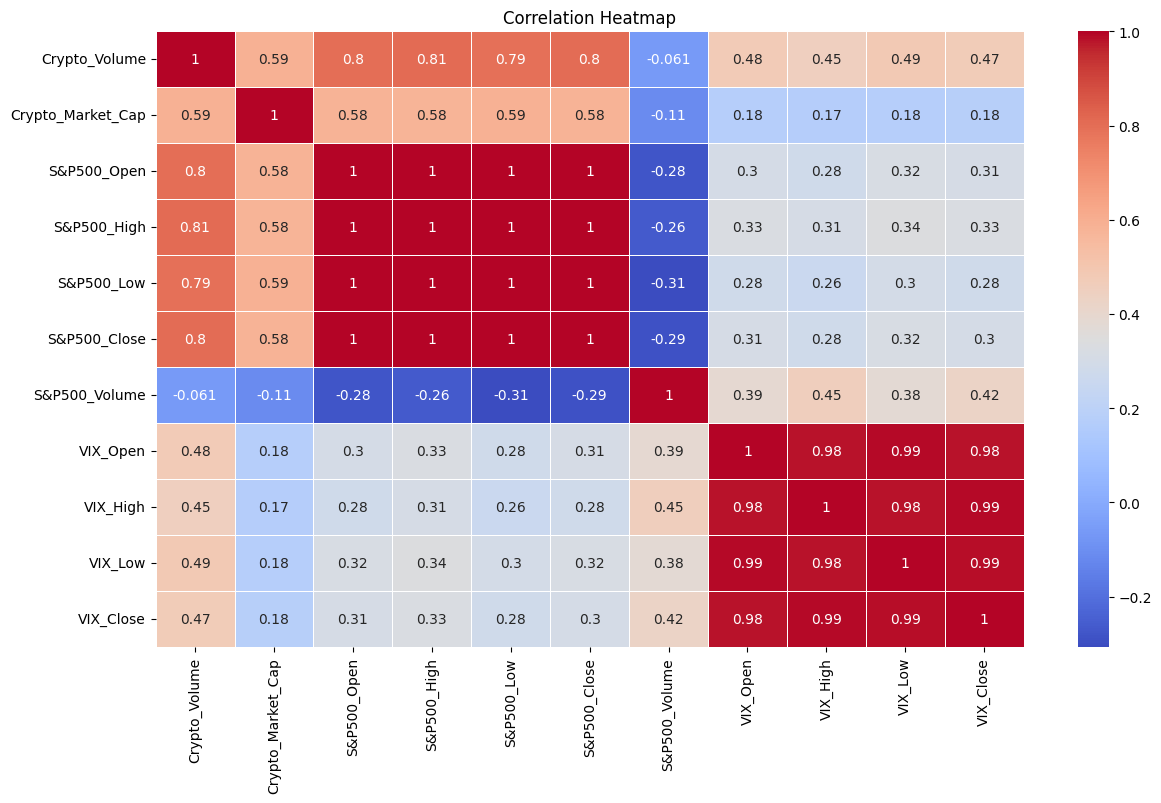

Crypto_Market_Cap    1.000000
S&P500_Low           0.588176
Crypto_Volume        0.586168
S&P500_Open          0.584351
S&P500_Close         0.584180
S&P500_High          0.579906
VIX_Close            0.177802
VIX_Open             0.176661
VIX_Low              0.175814
VIX_High             0.169385
S&P500_Volume       -0.110410
Name: Crypto_Market_Cap, dtype: float64

In [8]:
df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(14, 8))
sns.heatmap(df_numeric.corr("spearman"), linewidths=0.5, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

df_numeric.corr("spearman")["Crypto_Market_Cap"].sort_values(ascending = False)

Perfect, now we know that basically all of our features can help predict the crypto market cap!  
Let us prepare splitting the data and standardizing it to train our models by running the code below.

In [9]:
def split_time_series(df: pd.DataFrame, target_col: str, train_ratio: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits the time series dataset into train, validation, and test sets in a sequential manner.

    Args:
        df (pd.DataFrame): The input DataFrame (sorted by date).
        target_col (str): The name of the target column.
        train_ratio (float): The proportion of data to allocate for training (e.g., 0.8 means 80% for train, 10% for validation, 10% for test).

    Returns:
        tuple: DataFrames and Series for train, validation, and test sets (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    # Ensure the data is sorted by time
    df = df.sort_values(by="Date")

    if not (0 < train_ratio < 1):
        raise ValueError("train_ratio must be between 0 and 1.")

    # Define split indices
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * ((1 - train_ratio) / 2))

    # Sequential split
    train_data = df.iloc[:train_size]
    val_data = df.iloc[train_size:train_size + val_size]
    test_data = df.iloc[train_size + val_size:]

    # Extract features and target
    X_train, y_train = train_data.drop(columns=[target_col, "Date"]), train_data[target_col]
    X_val, y_val = val_data.drop(columns=[target_col, "Date"]), val_data[target_col]
    X_test, y_test = test_data.drop(columns=[target_col, "Date"]), test_data[target_col]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_time_series(df, 'Crypto_Market_Cap', train_ratio=0.75)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (1030, 10) (1030, 1)
Validation shapes: (171, 10) (171, 1)
Test shapes: (173, 10) (173, 1)


## Training Models

These are a couple of helper functions, and variables that will help us asses our models!

In [144]:
TRAIN_SIZE = len(X_train)
VAL_SIZE = len(X_val)
TEST_SIZE = len(X_test)
TRAIN_INDICES = df.index[:TRAIN_SIZE]
VAL_INDICES = df.index[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
TEST_INDICES = df.index[TRAIN_SIZE + VAL_SIZE:]

def mean_directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates Mean Directional Accuracy (MDA).
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        float: MDA score between 0 and 1.
    """
    return np.mean(np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten())))

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> dict[str, float]:
    """
    Evaluates the model on different metrics.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
    
    Returns:
        dict: Dictionary of metric names and their values.
    """

    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
        "MDA": mean_directional_accuracy(y_true, y_pred)
    }

def print_evaluation_metric_results(results: dict[str, float], set: str) -> None:
    """
    Prints the evaluation results in a formatted and readable way.
    
    Args:
        results (dict): Evaluation results on a specific set.
        set (str): The name of the set (e.g., train, validation, test).
    """
    print("=" * 42)
    print(f"📊 Model Evaluation On {set} Set 📊")
    print("=" * 42)
    for metric, value in results.items():
        print(f"➡️ {metric}: {value:.4f}")
    print("=" * 42)

def plot_predictions(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    indices: pd.Index,
    title: str
) -> None:
    """
    Plots true vs predicted values.
    
    Args:
        y_true (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.
        indices (pd.Index): Indices for the samples.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(indices, y_true, label='True Values', color='blue')
    plt.plot(indices, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Scaled Market Cap')
    plt.legend()
    plt.show()

def plot_loss_curves(train_losses: list, val_losses: list) -> None:
    """
    Plots training and validation loss curves.
    
    Args:
        train_losses (list): List of training losses per epoch
        val_losses (list): List of validation losses per epoch
    """
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

Side note about metrics:
- **MSE/RMSE**: Values closer to 0 indicates higher accuracy.
- **R²**: A score closer to 1 is ideal, meaning the model fits the data well. A negative value indicates poor predictive performance.
- **MDA**: A score above 0.5 suggests better-than-random prediction, while a score close to 1 is ideal.  

Let us start first with a very simple model and see how it performs. Then we can go from there.

### Linear Regression

📊 Model Evaluation On Training Set 📊
➡️ MSE: 0.8642
➡️ RMSE: 0.9296
➡️ R²: 0.1358
➡️ MDA: 0.5549
📊 Model Evaluation On Validation Set 📊
➡️ MSE: 8.9805
➡️ RMSE: 2.9968
➡️ R²: -1.1288
➡️ MDA: 0.4471
📊 Model Evaluation On Test Set 📊
➡️ MSE: 168.4162
➡️ RMSE: 12.9775
➡️ R²: -13.8332
➡️ MDA: 0.4709


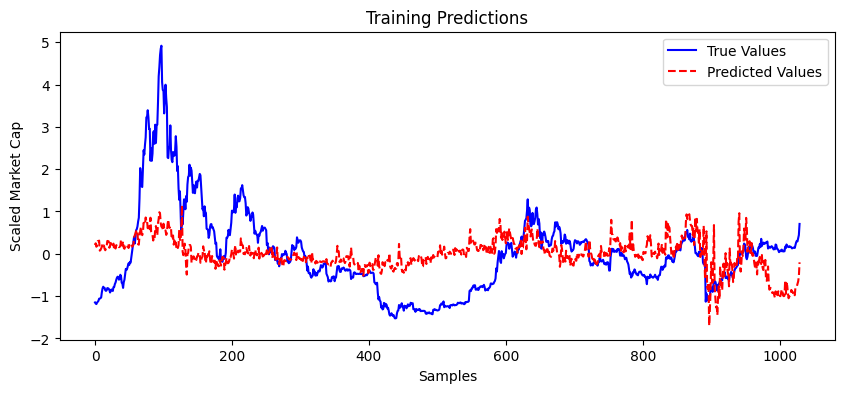

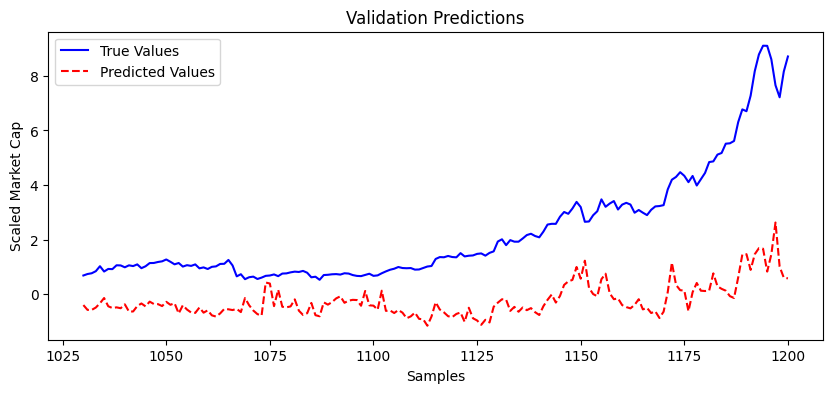

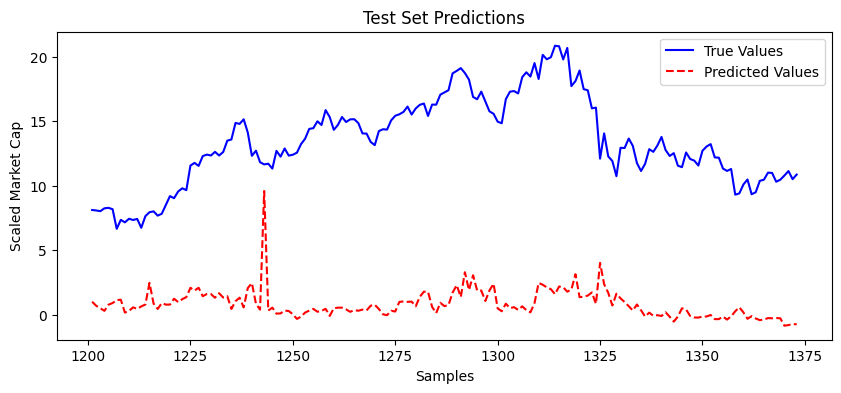

In [145]:
# Train model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lin_model.predict(X_train)
y_val_pred = lin_model.predict(X_val)
y_test_pred = lin_model.predict(X_test)

# Evaluate
train_results = evaluate_model(y_train, y_train_pred)
val_results = evaluate_model(y_val, y_val_pred)
test_results = evaluate_model(y_test, y_test_pred)

# Print metric results
print_evaluation_metric_results(train_results, 'Training')
print_evaluation_metric_results(val_results, 'Validation')
print_evaluation_metric_results(test_results, 'Test')

# Plot predictions
plot_predictions(y_train, y_train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, y_val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, y_test_pred, TEST_INDICES, "Test Set Predictions")

As we can see from the metrics the model performs poorly. In fact, the linear regression model is too simple for this type of problem. That is why it cannot fit the data properly. We were expecting that. This is proven by the MSE and RMSE metric. Both are very high which means that the model's predictions deviates significantly from the actual values. The R² is also negative showing that the model cannot follow the trend of the data. Finally, the MDA score is lower than 0.5 which shows that the model is poor when detecting the direction of the market cap change.

Let us move on to a more complex model: **ANNs**  
Run the cell below for some additional helper functions.

In [146]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    epochs: int,
    print_every: int = 100
) -> tuple[list, list]:
    """Trains the model and returns loss histories."""
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        
        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if (epoch + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}] ==> Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses

In [150]:
class ANNCryptoMarketCapPredictor(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

Epoch [100/500] ==> Train Loss: 0.2386, Val Loss: 7.0617
Epoch [200/500] ==> Train Loss: 0.1327, Val Loss: 6.4222
Epoch [300/500] ==> Train Loss: 0.1056, Val Loss: 5.7653
Epoch [400/500] ==> Train Loss: 0.0886, Val Loss: 5.4740
Epoch [500/500] ==> Train Loss: 0.0763, Val Loss: 5.1392
📊 Model Evaluation On Training Set 📊
➡️ MSE: 0.0778
➡️ RMSE: 0.2790
➡️ R²: 0.9222
➡️ MDA: 0.5578
📊 Model Evaluation On Validation Set 📊
➡️ MSE: 5.1392
➡️ RMSE: 2.2670
➡️ R²: -0.2182
➡️ MDA: 0.5118
📊 Model Evaluation On Test Set 📊
➡️ MSE: 146.4724
➡️ RMSE: 12.1026
➡️ R²: -11.9005
➡️ MDA: 0.5349


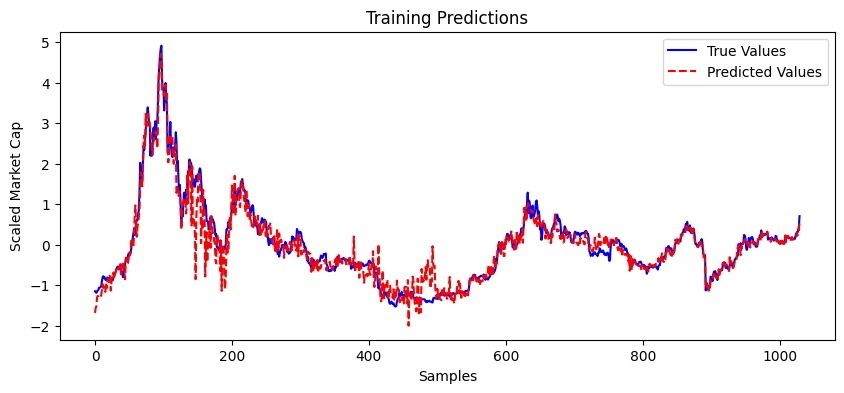

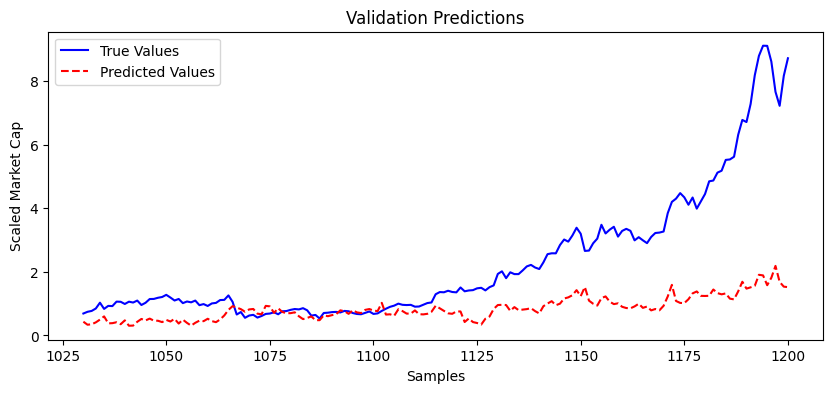

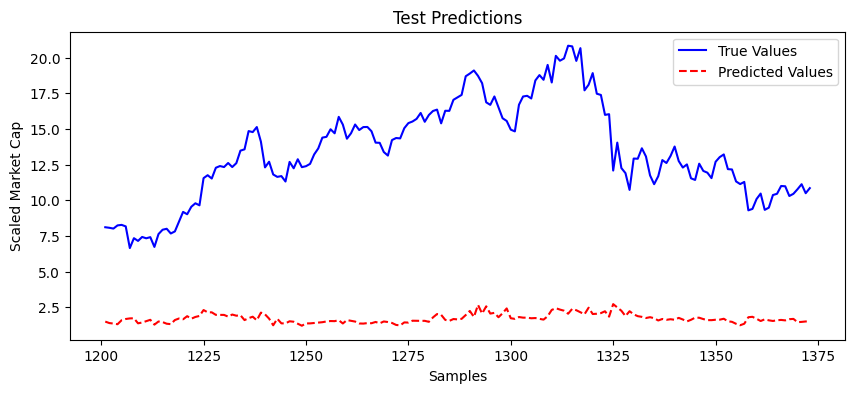

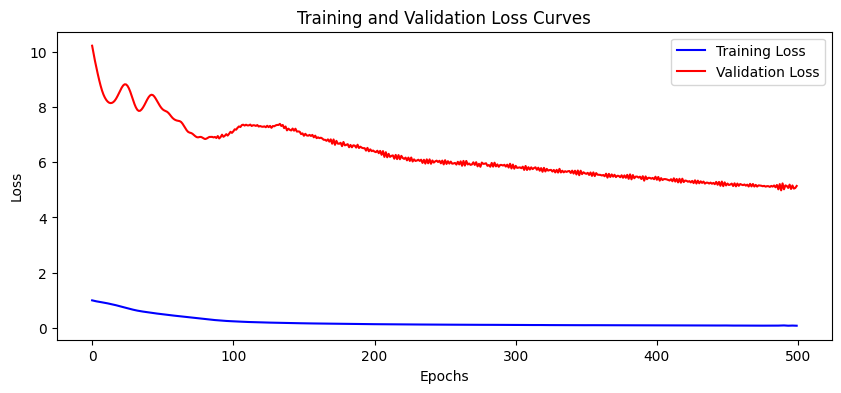

In [151]:
# Hyperparameters
input_size = X_train.shape[1]
lr = 0.001
epochs = 500

# Initialize model
model = ANNCryptoMarketCapPredictor(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_losses, val_losses = train_model(
    model, criterion, optimizer,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    epochs
)

model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    val_pred = model(X_val_tensor)
    test_pred = model(X_test_tensor)
    
    train_metrics = evaluate_model(y_train_tensor.detach().numpy(), train_pred)
    val_metrics = evaluate_model(y_val_tensor.detach().numpy(), val_pred)
    test_metrics = evaluate_model(y_test_tensor.detach().numpy(), test_pred)

# Print metric results
print_evaluation_metric_results(train_metrics, "Training")
print_evaluation_metric_results(val_metrics, "Validation")
print_evaluation_metric_results(test_metrics, "Test")

# Plot predictions and loss curves
plot_predictions(y_train, train_pred, TRAIN_INDICES, "Training Predictions")
plot_predictions(y_val, val_pred, VAL_INDICES, "Validation Predictions")
plot_predictions(y_test, test_pred, TEST_INDICES, "Test Predictions")
plot_loss_curves(train_losses, val_losses)

## **Experimental Setup**
Describe the datasets used for your experiments. List the machine learning techniques used to solve your problem and report the corresponding hyperparameters.

In this section, you can add **text**, **tables**, and **figures**.

## **Experimental Results**
Describe here the main experimental results. Critically discuss them. Compare them with results available in the literature (if applicable).

In this section, you can add **text** and **figures**, **tables**, **plots**, and code. Make sure the code is runnable and replicable.

## **Conclusions**

Summarize what you could and could not conclude based on your experiments.
In this section, you can add **text**.



## **References**
You can add here the citations of books, websites, or academic papers, etc.

https://medium.com/analytics-vidhya/principal-steps-of-a-machine-learning-project-7d7dcc6fe68b  
https://ishanjainoffical.medium.com/choosing-the-right-correlation-pearson-vs-spearman-vs-kendalls-tau-02dc7d7dd01d  
https://en.wikipedia.org/wiki/Mean_directional_accuracy#:~:text=Mean%20directional%20accuracy%20(MDA)%2C,to%20the%20actual%20realized%20direction.  
https://emojipedia.org/
https://jillanisofttech.medium.com/building-an-ann-with-pytorch-a-deep-dive-into-neural-network-training-a7fdaa047d81  
